# Models with more covariates

In [ ]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)
library(VIM)

# library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)

source('Rutils/functions.R')

In [4]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

In [5]:
country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

In [6]:
df[, ctry := factor(ctry, labels=country_labels)]

In [222]:
# intrapolation?
# x <- 1:10
# y <- rnorm(10)

# plot(x, y, main = "approx(.) and approxfun(.)")
# # points(approx(x, y), col = 2, pch = "*")
# points(approx(y, method = "linear"), col = 4, pch = "*")

# Only male-female average and records since 1900

In [7]:
covariates = names(df)[10:28]

In [8]:
c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max), 
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

In [9]:
(nrow(c) + nrow(le))/2

[1] 1848

In [10]:
dt = merge(c, le, by=c('ctry', 'year'))

In [11]:
# missing data
print(countmis(dt))

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


In [14]:
# md.pattern(dt)

In [15]:
test = mice(dt, m=10, method='cart', printFlag=FALSE)

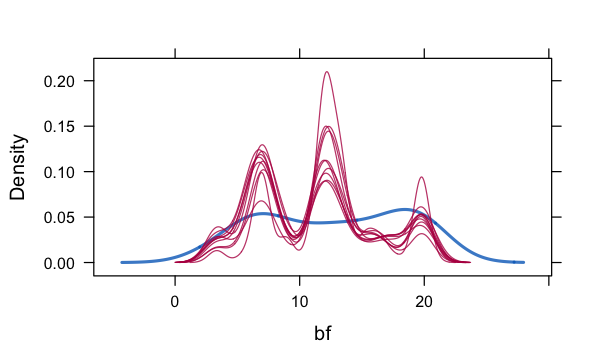

In [16]:
densityplot(test, ~bf)

In [259]:
# missing data?
# total = total[complete.cases(total[, .(Ex, gdp_pc)])]

# total= total[, .(ctry, year, gdp_pc, Ex)]
# setnames(total, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [260]:
dt[, le_log := scale(log(le), scale=FALSE)]
dt[, gdp_log := scale(log(gdp), scale=FALSE)]
dt[, year_log := scale(log(year), scale=FALSE)]

In [261]:
# year recode based on the criteria proposed by Alberto
dt[year<1950, gyear:=1]
dt[year>=1950 & year<1970, gyear:=2]
dt[year>=1970 & year<1990, gyear:=3]
dt[year>=1990, gyear :=4]
dt[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [262]:
# transform variable: weibull
dt[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
dt[, wy := log(-log(1-y))]

max_le = dt[, .(max_le = max(le+1.05)), by = ctry] # to recover values later

### Bayesian model 

In [266]:
# check sample sizes
dt[, ctry_year := interaction(ctry, gyear)]

In [ ]:
m1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = dt)

In [ ]:
summary(m1)

### Examine GOF

In [379]:
pred = cbind(dtl[, .(ctry, year, le, gdp_log, le_log)], predict(m1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [380]:
pred = merge(pred, max_le, by = 'ctry')

In [381]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [275]:
max_ex = max(dt$le)+25.0
min_ex = min(dt$le)-25.0
max_year = max(dt$year)
min_year = min(dt$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))